PyNILM - Exploratory Data Analysis
---



## Preparing Environment

In [1]:
# # COLAB VERSION
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

import sys
sys.path.append('../') # enabling pynilm import
sys.path.append('C:\\Users\\DiegoCavalca\\Desktop\\phd-thesis\\src\\nilmtk') # enabling nilmtk

import numpy as np

from tqdm import tqdm
from pathlib import Path
from nilmtk.utils import print_dict
from matplotlib import pyplot as plt
from plotly import express as px
from collections import Counter

## Experiment Details - REDD

In [3]:
# Dataset informations
data_dir = Path(f'G:/Meu Drive/phd-thesis/datasets/')

redd_filepath = data_dir.joinpath('REDD/redd.h5')

In [4]:
from src.data import DataWrapper

# experiment params
sample_period = 2
building_redd = 3
appliances_redd = ['washer dryer', 'microwave', 'dish washer', 'fridge']

# RP parameters
time_delay = 1
embedding_dimension = 2

In [8]:
redd_train = DataWrapper(
    dataset_path=redd_filepath,
    building=building_redd, 
    appliances=appliances_redd,
    sample_period=sample_period,
    start='1-4-2011 00:00:00',
    end='29-4-2011 23:59:59',
    return_mode='dataframe',
    windows_size=None,
    windows_stride=None,
    get_activations=True,
    activations_type=int,
    debug=False
    )

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=16, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


In [6]:
from collections import Counter
for k, v in redd_train.activations.items():
    print(k, dict(Counter(v)))

washer dryer {1: 1}
microwave {0: 1}
dish washer {0: 1}
fridge {1: 1}


### Aggregated Power Consumption (Mains)

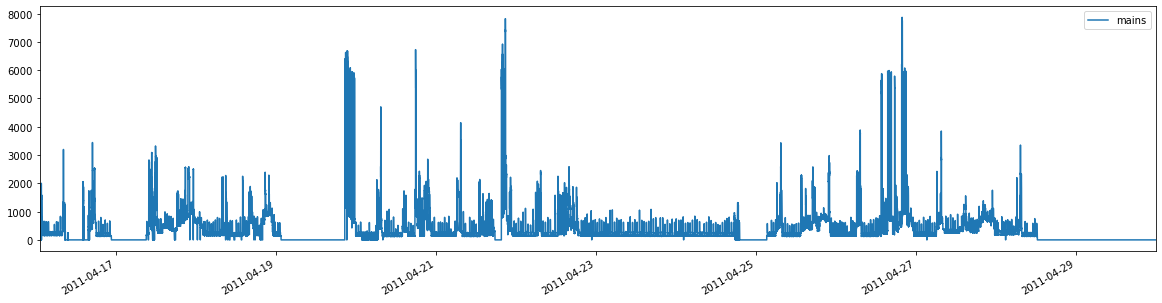

In [8]:
redd_train.data[['mains']].plot(figsize=(20, 5));

#### Extração de parâmetros RP - `Time Delay` e `Embedding Dimension`

In [9]:
mains_power_train = redd_train.data['mains'].values#[redd_train.data['mains'].columns[0]].values
mains_power_train

array([757.08997, 758.89   , 757.63995, ...,   0.     ,   0.     ,
         0.     ], dtype=float32)

In [10]:
from pynilm.timeseries import RecurrencePlot

rp_mains = RecurrencePlot(data=mains_power_train)

##### `Time Delay` - Método Informação Mútua

local_min: [0]


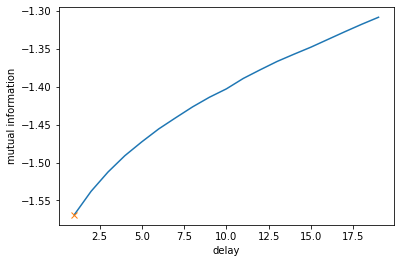

Delay = 1


(1, -1.5379467334076031)

In [11]:
delay, mutual_information = rp_mains.calculate_mutual_information(delay_range=20, debug=True)
delay, mutual_information

##### `Threshold` - Método Falsos Vizinhos

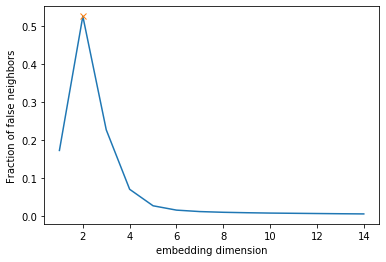

false_neighbors: [0.1730171556955283, 0.5257750262587176, 0.22724534851499278, 0.07087779615934105, 0.027516481182496843, 0.01612525864629466, 0.012293891882115366, 0.010423839762916552, 0.009268953982115864, 0.008346372812395773, 0.007778885833898884, 0.007179871801041056, 0.00661902209714647, 0.006146116281732395]

embedding_dimension = 2 (false_neighbors ~= 0.526)


(2, 0.5257750262587176)

In [12]:
embedding_dimension, false_neighbors = rp_mains.calculate_embedding_dimension(max_dimensions=15, debug=True)
embedding_dimension, false_neighbors

### Appliances Power Consumption

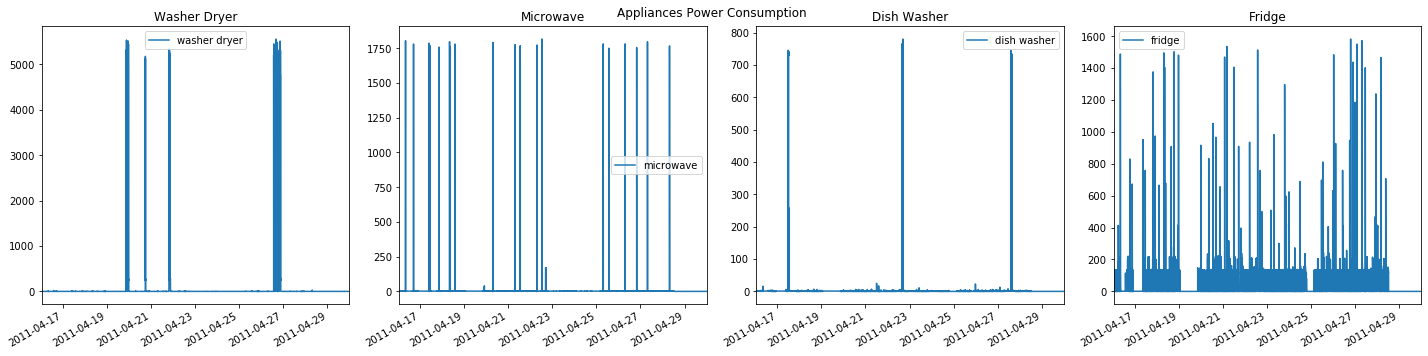

In [13]:
fig, axes = plt.subplots(1, len(appliances_redd), figsize=(20,5))

# Appliances power consumption
for a, ax in zip(appliances_redd, axes):
    redd_train.data[[a]].plot(ax=ax)
    ax.set_title(a.title())

plt.suptitle("Appliances Power Consumption")
plt.tight_layout()
plt.show()

### Power Consumption Overview 

In [35]:
fig = px.line(
    redd_train.data, 
    title=f"""Building #{building_redd} Power Consumption of {redd_train.dataset.metadata['name']} database<br><sup>From `{redd_train.start}` To `{redd_train.end}` (sample period = {sample_period})</sup>""",
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title="Power",
    legend_title="Legend",
)

fig.show(renderer='iframe')

In [36]:
# redd_train.data.plot(figsize=(20, 10))
# plt.title(f"""Building #{building_redd} Power Consumption of {redd_train.dataset.metadata['name']} database\n
# From `{redd_train.start}` To `{redd_train.end}` (sample period = {sample_period})""", size=14)
# plt.show()

### Windowing Time Series

#### Global Dataframe

In [27]:
# Generating windows from a single dataframe, containing ALL appliance data
redd_train = DataWrapper(
    dataset_path=redd_filepath,
    building=building_redd, 
    appliances=appliances_redd,
    sample_period=sample_period,
    start='1-4-2011 00:00:00',
    end='29-4-2011 23:59:59',
    return_mode='dataframe', 
    windows_size=1000, # --------------> HERE!!!
    windows_stride=1000, # --------------> HERE!!!
    get_activations=True,
    activations_type=int,
    debug=False
    )

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=16, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


Activation distribution by appliance:

washer dryer = {0: 18343, 1: 1546}
microwave = {0: 16558, 1: 3331}
dish washer = {0: 19167, 1: 722}
fridge = {1: 15675, 0: 4214}

------------------------------------------------

Mains/Appliance Activations examples:


Washer Dryer:


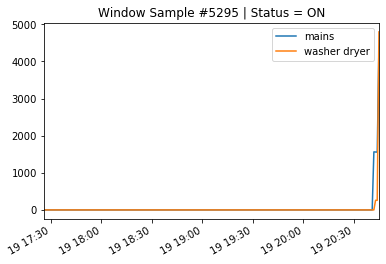

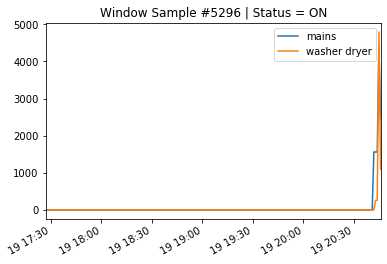

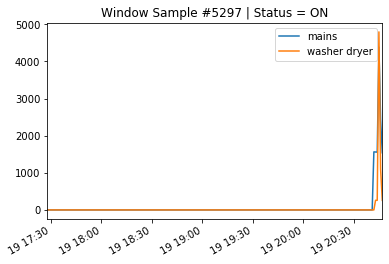

Microwave:


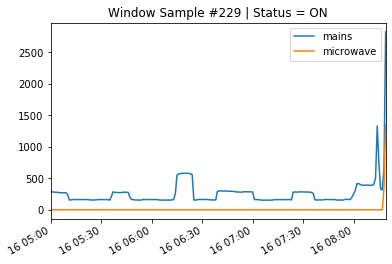

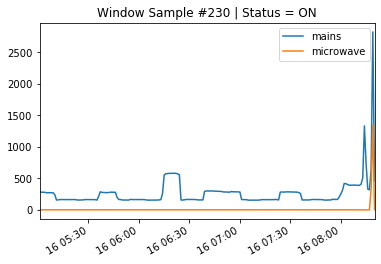

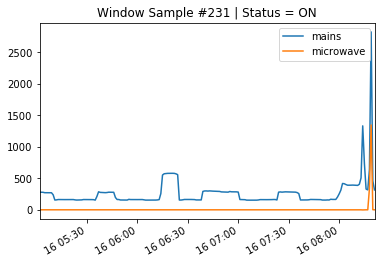

Dish Washer:


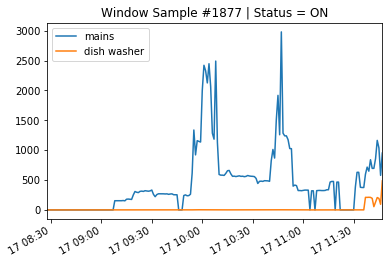

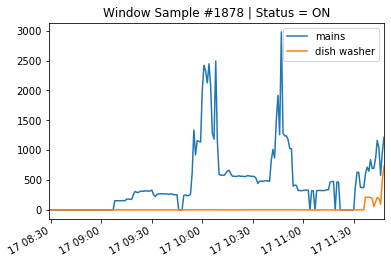

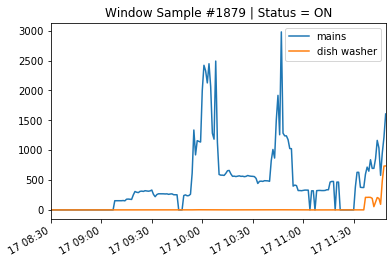

Fridge:


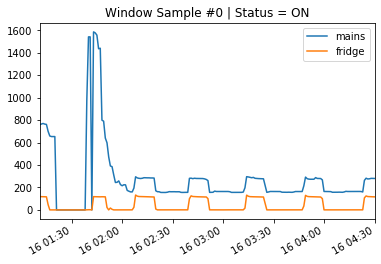

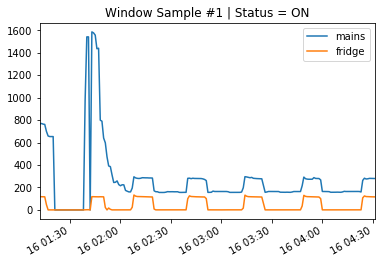

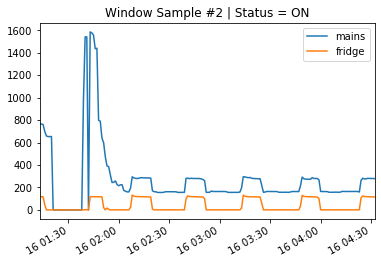

In [28]:
print('Activation distribution by appliance:\n')
for a, s in redd_train.activations.items():
    print(a, '=', dict(Counter(s)))
print('\n------------------------------------------------\n')

# Generating status
print('Mains/Appliance Activations examples:\n\n')
for a in appliances_redd:
    print(f'{a.title()}:')
    
    samples = 0
    for i in range(len(redd_train.data)):
        df = redd_train.data[i][[redd_train.mains_label, a]]
        status = redd_train.activations[a][i]
        
        if status and samples < 3:
            df.plot()
            plt.title(f'Window Sample #{i} | Status = {"ON" if status else "OFF"}')
            plt.show()
            samples += 1

In [30]:
import os
import imageio

# Salvando GIF a partir das janelas
filenames = []
for i, window in enumerate(redd_train.data[:1000]):
    # print('  -> window',i+1, '|', window.sum(), window.min(), window.max(), window.mean())
    # plt.plot(window)
    window.plot()
    plt.title(f'window {i+1}')
    # gif
    filename = f'images/window_{i+1}.png'
    filenames.append(filename)
    # gif - save frame
    plt.savefig(filename)
    plt.close()
# gif - build it
with imageio.get_writer(
    f'images/sample{redd_train.sample_period}_windows{redd_train.windows_size}_stride{redd_train.windows_stride}.gif', 
    mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
# gif - Remove files
for filename in set(filenames):
    os.remove(filename)

#### Individual Dataframes (dict)

In [12]:
# Generating windows from individual appliance dataframes, 
#  containing mains and appliance power consumptions information
redd_train = DataWrapper(
    dataset_path=redd_filepath,
    building=building_redd, 
    appliances=appliances_redd,
    sample_period=sample_period,
    start='1-4-2011 00:00:00',
    end='29-4-2011 23:59:59',
    data_mode='dict', # --------------> HERE!!!
    windows_size=1000, # --------------> HERE!!!
    get_activations=False,
    activations_type=int,
    debug=False
    )

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=16, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


In [13]:
print('Windows by Appliance:\n')
for k, v in redd_train.data.items():
    print(k, '=>', len(v), 'window samples')

Windows by Appliance:

washer dryer => 602 window samples
microwave => 602 window samples
dish washer => 602 window samples
fridge => 602 window samples
